In [2]:
import sys
sys.path.append("../src")
from linear_foraging import foraging_playground_linear
import numpy as np
from foraging_utils import optimal_linear, chance_linear, register_custom_env
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle
from matplotlib.ticker import MultipleLocator
import os

# Since single-life set-up, total session number = 1
# each session lasts 500000 trials
session_duration = 500000

### Setup Environment and Load Data

In [3]:
# environment setup
env_name = 'ForagingPlaygroundLinear-v0'
register_custom_env(
    env_name = env_name, 
    map_name = 'short',
    base_reward = 10.0,
    decay_rate = 0.6,
    reward_period = 10,
    session_duration = session_duration
)
env = gym.make(env_name)


**Chance/Optimal Performance**

In [4]:
'''Calculate the chance/optimal again'''
chance_reward, action_chance = chance_linear(env,10)
reward_optimal, action_optimal = optimal_linear(
        map_name = "short",
        base_reward = 10.0,
        decay_rate = 0.6,
        reward_period = 10,
        session_duration = session_duration
)
cum_reward_optimal = np.cumsum(reward_optimal)
cum_reward_optimal = np.concatenate((np.array([0]),cum_reward_optimal))

**Load foraging experiment results**

In [5]:
# Set plot path
plot_path = f'../figures/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [6]:
''' Load the data ''' 
n_env = 1
n_episode = 1

# load data from Prospective Forager
with open(f'../results/prospective_forager_wo_time.pkl', 'rb') as f:
    total_reward_prorager, total_action_prorager, _, _, prospective_total_reward_prorager, prospective_total_se_prorager = pickle.load(f)

with open(f'../results/prospective_forager_w_time.pkl', 'rb') as f:
    total_reward_time_prorager, total_action_time_prorager, _, _, prospective_total_reward_time_prorager, prospective_total_se_time_prorager = pickle.load(f)

# load data from Retrospective Forager
with open(f'../results/retrospective_forager.pkl', 'rb') as f:
    total_reward_retro, total_action_retro, _, _, prospective_total_reward_retro, prospective_total_se_retro = pickle.load(f)


In [7]:
''' Helper function to get stats we need for plotting '''
def get_prospective_stats(nth_rep, n_steps_per_update, prospective_total_reward, prospective_total_se):
    # nth_rep: which repetition of result to plot
    # n_steps_per_update: update step
    # se: standard error
    cum_pro_reward = []
    cum_pro_se = []

    pro_reward = []
    pro_se = []

    n_updates = 1 * session_duration//n_steps_per_update    

    for i in range(n_updates):
        pro_reward.extend(prospective_total_reward[nth_rep][i])#.cpu().numpy()
        pro_se.extend(prospective_total_se[nth_rep][i])
    cum_pro_reward = np.cumsum(pro_reward)
    cum_pro_se = np.sqrt(np.cumsum(np.array(pro_se)**2))

    return cum_pro_reward, cum_pro_se

In [8]:
# For prorager, choose rep 5 to plot
cum_reward_prorager = np.cumsum(total_reward_prorager[5][0])
cum_pro_reward_prorager, cum_pro_se_prorager = get_prospective_stats(5, 40, prospective_total_reward_prorager, prospective_total_se_prorager)
action_total_prorager = total_action_prorager[5][0]

# For time_prorager, choose rep 4 to plot
cum_reward_time_prorager = np.cumsum(total_reward_time_prorager[4][0])
cum_pro_reward_time_prorager, cum_pro_se_time_prorager = get_prospective_stats(4, 100, prospective_total_reward_time_prorager, prospective_total_se_time_prorager)
action_total_time_prorager = total_action_time_prorager[4][0]


# retrospective agent, choose rep 0 to plot
cum_reward_retro = np.cumsum(total_reward_retro[0][0])
cum_pro_reward_retro, cum_pro_se_retro = get_prospective_stats(0, 40, prospective_total_reward_retro, prospective_total_se_retro)
action_total_retro = total_action_retro[0][0]

In [9]:
colors = [
    (51/255, 187/255, 238/255),  # Cyan: prospective agent without time
    (0/255, 153/255, 136/255),  # Teal: retrospective agent
    (204/255, 51/255, 17/255),  # Red: prospective agent with time
    (0/255,68/255, 136/255),  # Dark blue: optimal performance
    (255/255, 217/255, 114/255) # yellow: chance performance
]

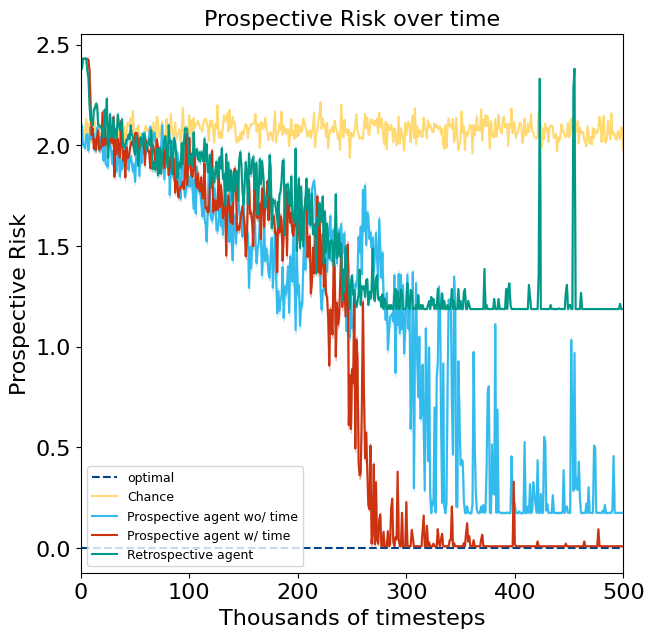

In [10]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7, 7))

interval_size =  1000
# episode return
x = np.arange(interval_size, len(cum_reward_prorager)+1, interval_size)  # Steps at intervals

# optimal
slopes_optimal = (cum_reward_optimal[x-1] - cum_reward_optimal[x - interval_size]) / interval_size  # Reward slope
ax.plot(x, slopes_optimal - slopes_optimal, linestyle='--', label ="optimal", c = colors[3]) 
ax.set_ylabel("Reward Rate")

# chance
cum_chance = np.cumsum(chance_reward)
slopes_chance = (cum_chance[x-1] - cum_chance[x - interval_size]) / interval_size  # Reward slope
ax.plot(x, slopes_optimal - slopes_chance, color=colors[4], linestyle='-', label="Chance") 


slope_prorager = (cum_reward_prorager[x-1] - cum_reward_prorager[x - interval_size]) / interval_size  # Reward slope
slopes_se_prorager = np.sqrt(cum_pro_se_prorager[x-1]**2 - cum_pro_se_prorager[x-interval_size]**2) / interval_size
slope_time_prorager = (cum_reward_time_prorager[x-1] - cum_reward_time_prorager[x - interval_size]) / interval_size  # Reward slope
slopes_se_time_prorager = np.sqrt(cum_pro_se_time_prorager[x-1]**2 - cum_pro_se_time_prorager[x-interval_size]**2) / interval_size
slope_retro = (cum_reward_retro[x-1] - cum_reward_retro[x - interval_size]) / interval_size  # Reward slope
slopes_se_retro = np.sqrt(cum_pro_se_retro[x-1]**2 - cum_pro_se_retro[x-interval_size]**2) / interval_size

ax.plot(
    x, slopes_optimal - slope_prorager, c = colors[0],label = f'Prospective agent wo/ time' 
) # Cyan
ax.fill_between(
        x, 
        (slopes_optimal - slope_prorager) - slopes_se_prorager, 
        (slopes_optimal - slope_prorager) + slopes_se_prorager, 
        color=colors[0], alpha=0.3
    )

ax.plot(
    x, slopes_optimal - slope_time_prorager, c = colors[2],label = f'Prospective agent w/ time'
) # red
ax.fill_between(
        x, 
        (slopes_optimal - slope_time_prorager) - slopes_se_time_prorager, 
        (slopes_optimal - slope_time_prorager) + slopes_se_time_prorager, 
        color=colors[2], alpha=0.3
    )

ax.plot(
    x, slopes_optimal - slope_retro, c = colors[1],label = f'Retrospective agent' 
) # Teal
ax.fill_between(
        x, 
        (slopes_optimal - slope_retro) - slopes_se_retro, 
        (slopes_optimal - slope_retro) + slopes_se_retro, 
        color=colors[1], alpha=0.3
    )

ax.legend(fontsize = 9, loc = 'lower left')
ax.set_title("Prospective Risk over time", fontsize = 16)
ax.set_xlabel("Thousands of timesteps")
ticks = plt.gca().get_xticks()
ax.set_xticks(ticks=ticks, labels=[f"{int(tick // 1000)}" for tick in ticks])  # Divide by 1000 and format
ax.set_xlim([0, 500000])
ax.set_ylabel("Prospective Risk")
plt.savefig(f'{plot_path}7_prospective_risk.pdf')
plt.show()

**Plot the selected actions**

In [ ]:
# STAY = 0, anything else = anything else
plt.rcParams.update({'font.size': 14})
actions_to_plot = [action_total_retro, action_total_prorager, action_total_time_prorager]
colors_to_use = [colors[1], colors[0], colors[2]]
labels_to_use = ['Retrospective Agent', 'Prospective Agent w/o time', 'Prospective Agent w/ time']
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 5))
fig.suptitle(
    f"Actions for the last 100 steps"
)

for i in range(3):
    # optimal action
    action_optimal_ =  np.array([em.item() for em in action_optimal[-100:]])
    if i == 2:
        axs[i].plot(action_optimal_, label ="optimal", c = colors[1])
    else:
        axs[i].plot(action_optimal_, c = colors[3])
        axs[i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    axs[i].set_xlim(left = 0, right = 100)

    actions_this_rep = actions_to_plot[i]
    actions_this_rep = np.array([em.item() for em in actions_this_rep[-100:]])
    '''Compare agent with optimal'''
    # best episode action
    actions_this_rep[actions_this_rep != 0] = 1
    axs[i].plot(actions_this_rep, label=labels_to_use[i], c = colors_to_use[i])
    axs[i].set_yticks([0,1])
    axs[i].set_yticklabels(['STAY','MOVE'])
    axs[i].set_ylim([-1.2,2.2])
    axs[i].xaxis.set_major_locator(MultipleLocator(10))  # Major grid lines every 10 x-units
    axs[i].grid(which='major', color='grey', linestyle='-', linewidth=0.5)
    

handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
fig.supxlabel("Time (t)")
fig.supylabel("Action")

fig.legend(handles, labels, loc='upper right', frameon=False, fontsize = 6)

plt.tight_layout()
plt.savefig(f'{plot_path}7_agents_actions.pdf')
plt.show()
